In [3]:
import pandas as pd
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt

Lectura:
- VEI indice para clasificar volcanes: https://en.wikipedia.org/wiki/Volcanic_explosivity_index
- Stromboli Volcán: https://www.volcanodiscovery.com/es/stromboli.html
- Influencia de un volcan en las bajas temperaturas: https://scied.ucar.edu/learning-zone/how-climate-works/how-volcanoes-influence-climate
- Explicación de aumento de temperatura:https://berkeley-earth-wp-offload.storage.googleapis.com/wp-content/uploads/2022/12/03232411/skeptics-guide-to-climate-change-1.pdf
- Temperaturas de japon + analisis con volcan: https://berkeleyearth.org/temperature-location/36.17N-139.23E
- Isolation forest para detectar anomalias: 
    - https://youtu.be/Y1x51i1936M?si=OgrbuUsvdB7DLipY
    - https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html

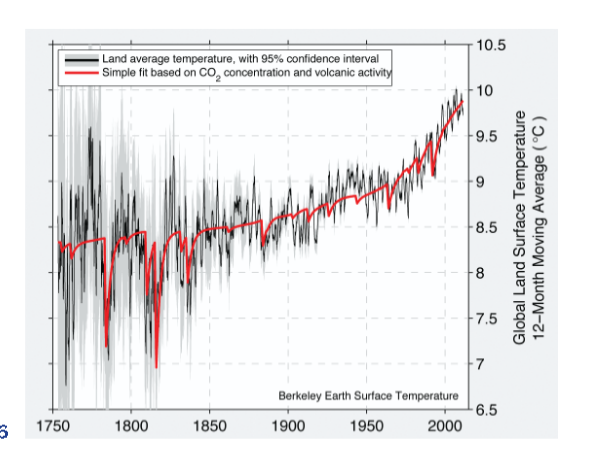

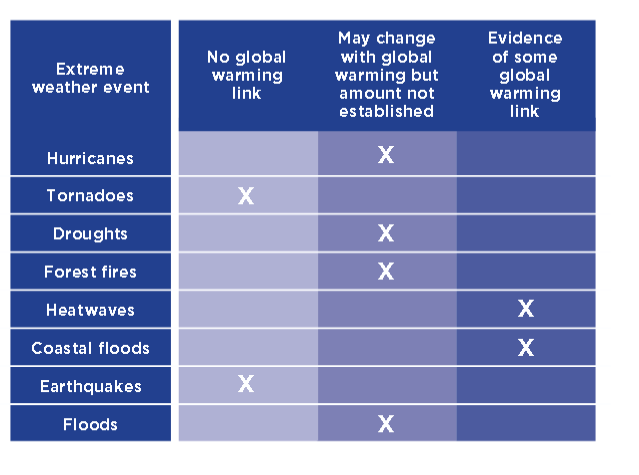

In [85]:
def plot_volcans(dt=pd.to_datetime('1750-01-01')):

    volcanes = {
    "Tambora\nVEI 7"     : {"fecha": "1812-01-01" , "ha": "center"},
    "Krakatau\nVEI 6"    : {"fecha": "1883-05-20" , "ha": "right"},
    "Santa\nMaría\nVEI 6" : {"fecha": "1902-10-24" , "ha": "center"},
    "Novarupta\nVEI 6"   : {"fecha": "1912-06-06" , "ha": "left"},
    "Pinatubo\nVEI 6"    : {"fecha": "1991-04-02" , "ha": "center"},
    }

    for nombre, data in volcanes.items():
        fecha_dt = pd.to_datetime(data['fecha'])
        if fecha_dt >= dt:
            plt.axvline(
                fecha_dt,
                color="red",
                linestyle="--",
                alpha=0.4,
            )
            plt.text(
                fecha_dt,
                plt.ylim()[1],
                nombre,
                fontsize="smaller",
                color="red",
                ha=data["ha"],
                va="bottom",
            )


Carga y preprocesado rapido

In [4]:
def coord_to_float(s: str) -> float:
    sign = -1 if s[-1] in ['S', 'W'] else 1
    return sign * float(s[:-1])

In [5]:
MajorCityCsv = './GlobalLandTemperaturesByMajorCity.csv'

In [6]:
MajorCityDf = pd.read_csv(
    MajorCityCsv,
    dtype_backend='pyarrow',
    engine='pyarrow'
)
MajorCityDf['year'] = MajorCityDf.dt.dt.year
MajorCityDf['month'] = MajorCityDf.dt.dt.month
MajorCityDf = MajorCityDf.sort_values('dt').reset_index().drop(['index'], axis=1)
MajorCityDf['Latitude'] = MajorCityDf['Latitude'].apply(coord_to_float)
MajorCityDf['Longitude'] = MajorCityDf['Longitude'].apply(coord_to_float)

MajorCityDf.head(2)

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,year,month
0,1743-11-01,6.326,1.601,Berlin,Germany,52.24,13.14,1743,11
1,1743-11-01,5.436,2.205,Chicago,United States,42.59,-87.27,1743,11


In [7]:
cols = ['AverageTemperature', 'AverageTemperatureUncertainty']

MajorCityDf[cols] = (
    MajorCityDf
    .groupby('City')[cols]
    .apply(lambda s: s.interpolate(method='linear', limit_direction='forward'))
    .reset_index(level=0, drop=True)
)

Nuevo tipo de grafico suavizado con una media movil de 12 meses (cada mes es el promedio de ese vs los 11 anteriores)

In [8]:
MajorCityDf["MA12"] = (
    MajorCityDf
    .groupby(["Country", "City"])["AverageTemperature"]
    .transform(lambda x: x.rolling(12, min_periods=1, center=True).mean())
)
MajorCityDf.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,year,month,MA12
0,1743-11-01,6.326,1.601,Berlin,Germany,52.24,13.14,1743,11,7.9310
1,1743-11-01,5.436,2.205,Chicago,United States,42.59,-87.27,1743,11,7.1010
2,1743-11-01,10.365,2.325,Istanbul,Turkey,40.99,29.82,1743,11,12.0505
3,1743-11-01,0.895,2.092,Kiev,Ukraine,50.63,31.69,1743,11,5.3575
4,1743-11-01,7.541,1.753,London,United Kingdom,52.24,-0.00,1743,11,7.9185


In [60]:
# Se promedia antes por cada ciudad para evitar el peso de ciudades con más pesos
CountryMonthly = (
    MajorCityDf
    .groupby(['dt', "Country", "year", "month"])["MA12"]
    .mean()
    .reset_index()
)
CountryMonthly.head()

,dt,Country,year,month,MA12
0,1743-11-01,Canada,1743,11,2.2740
1,1743-11-01,France,1743,11,8.9215
2,1743-11-01,Germany,1743,11,7.9310
3,1743-11-01,Italy,1743,11,10.2010
4,1743-11-01,Russia,1743,11,1.9175


In [62]:
GlobalMonthly = (
    CountryMonthly
    .groupby(['dt','year', 'month'])['MA12']
    .mean()
    .reset_index()
)
GlobalMonthly.head()
GlobalMonthly['dt']= pd.to_datetime(GlobalMonthly['dt'])
GlobalMonthly.set_index('dt', inplace=True )
GlobalMonthly.head(3)

,year,month,MA12
dt,,,
1743-11-01,1743,11,7.230550
1743-12-01,1743,12,7.973579
1744-01-01,1744,1,9.104625


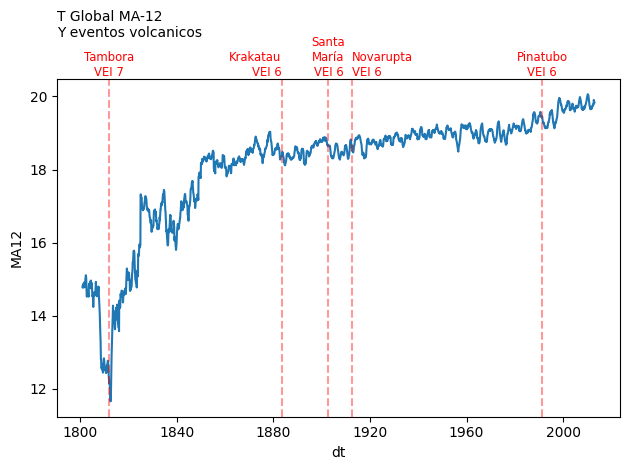

In [100]:
sn.lineplot(
    GlobalMonthly[(GlobalMonthly['year'] > 1800) & (GlobalMonthly['year'] < 2013)],
    x='dt',
    y='MA12'
)

plt.title('T Global MA-12\nY eventos volcanicos', loc='left', fontsize=10, pad=30)
plt.tight_layout()

plot_volcans()

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [13]:
df = (
    MajorCityDf.groupby(['dt','year','month'])
    .agg(
        mean_t=('AverageTemperature', 'mean'),
        mean_uncertainty = ('AverageTemperatureUncertainty', 'mean')
    )
    .reset_index()
)
df = df[df['year'] > 1799]
df.set_index('dt', inplace=True)

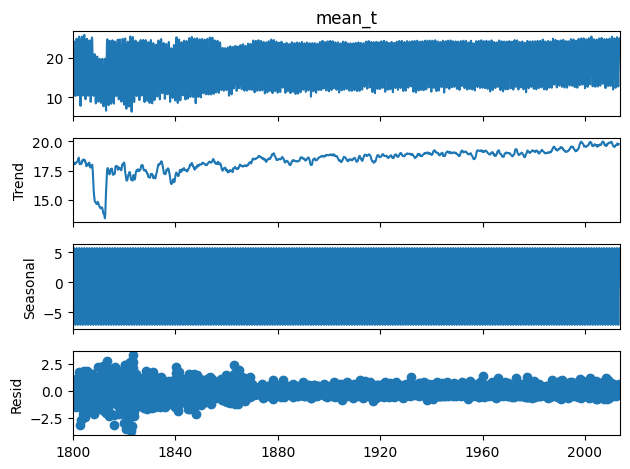

In [14]:
feature = "mean_t"
decompose = seasonal_decompose(df[feature] , model="additive", period=12)
decompose.plot();

In [15]:
from sklearn.ensemble import IsolationForest

In [16]:
resid = decompose.resid.dropna()
X = resid.values.reshape(-1,1)

In [17]:
mu = resid.mean()
std = resid.std()
z = (resid - mu )/std
rto = z[ z.abs() > 3 ].count()
rt = resid.count()
z_score = rto/rt
print(f'zscore: {z_score}')
print(f'count: {rto}')

zscore: 0.019193106149627888
count: 49


In [18]:
hparams = {
    'n_estimators': {1,5,10,50,100,150,200},
    'contamination': {z_score -0.015, z_score, z_score + 0.015},
    'random_state': 42,
    'verbose': 2,
    'warm_start': True

}

In [19]:
# Returns -1 for outliers and 1 for inliers.
iso_forest = IsolationForest(
    random_state=42,
    verbose=0,
)

pred = iso_forest.fit_predict(X)

In [20]:
np.sum([pred == -1])

np.int64(433)

In [21]:
df_iso = df.loc[resid.index].copy()
df_iso["iso_label"] = pred
df_iso['resid'] = resid
outliers_df = df_iso[df_iso["iso_label"] == -1]

In [22]:
df_iso = df_iso.reset_index()
df_iso['dt'] = df_iso['dt'].astype("datetime64[ns]")
df_iso=df_iso.set_index('dt')


outliers_df = outliers_df.reset_index()
outliers_df['dt'] = outliers_df['dt'].astype("datetime64[ns]")
outliers_df=outliers_df.set_index('dt')

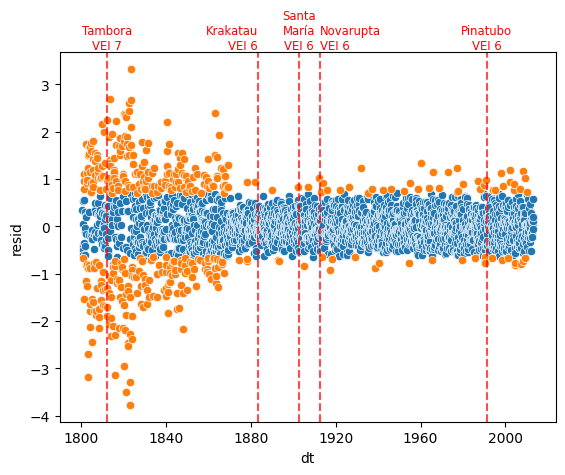

In [50]:
sn.scatterplot(
    df_iso,
    y='resid',
    x='dt'
)
sn.scatterplot(
    outliers_df,
    y='resid',
    x='dt'
)

plot_volcans()

plt.show()
